In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler


/Users/shrutikaushal/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
os.getcwd()

'/Users/shrutikaushal/Documents/GitHub/Prediction-of-commercial-insurance-payments-for-surgical-procedure-using-DataRobot'

In [3]:
path = os.getcwd()

In [4]:
group_df = pd.read_excel(path+
    '/Data_Files/JnJ_Files/cost_discharge_physpec_ippct.xlsx')

data = pd.read_csv(path+
    '/Data_Files/JnJ_Files/priv_mcare_f_pay_2022Oct18.csv')

In [5]:
group_df.head()

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct
0,ankle_fix,16741.5136,0.621714,ORTHOPEDIC SURGERY (ORS),0.542798
1,ant_cerv_fusion,18848.1697,0.846973,NEUROLOGICAL SURGERY (NS),0.575495
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543
3,bariatric,14585.5550,0.945035,GENERAL SURGERY (GS),0.911311
4,breast reconstruction,13690.8043,0.929970,PLASTIC SURGERY (PS),0.246127


In [6]:
group_df['group'] = list(map(lambda s: s.replace('\xa0',' '), group_df['group'].to_list()))
group_df['phy_spec'] = list(map(lambda s: s.replace('\xa0',' '), group_df['phy_spec'].to_list()))

In [7]:
data['group'] = list(map(lambda s: s.replace('\xa0',' '), data['group'].to_list()))

## Normalizing features

In [7]:
m = StandardScaler()
norm_group_df = group_df.copy()[['pat_cost','discharge_to_home_pct','IP_pct']]

norm_group_df = m.fit_transform(norm_group_df.values)
norm_group_df = pd.DataFrame(norm_group_df)
norm_group_df.columns = ['pat_cost','discharge_to_home_pct','IP_pct']

### Visualizing the normalized numerical features

<IPython.core.display.Javascript object>


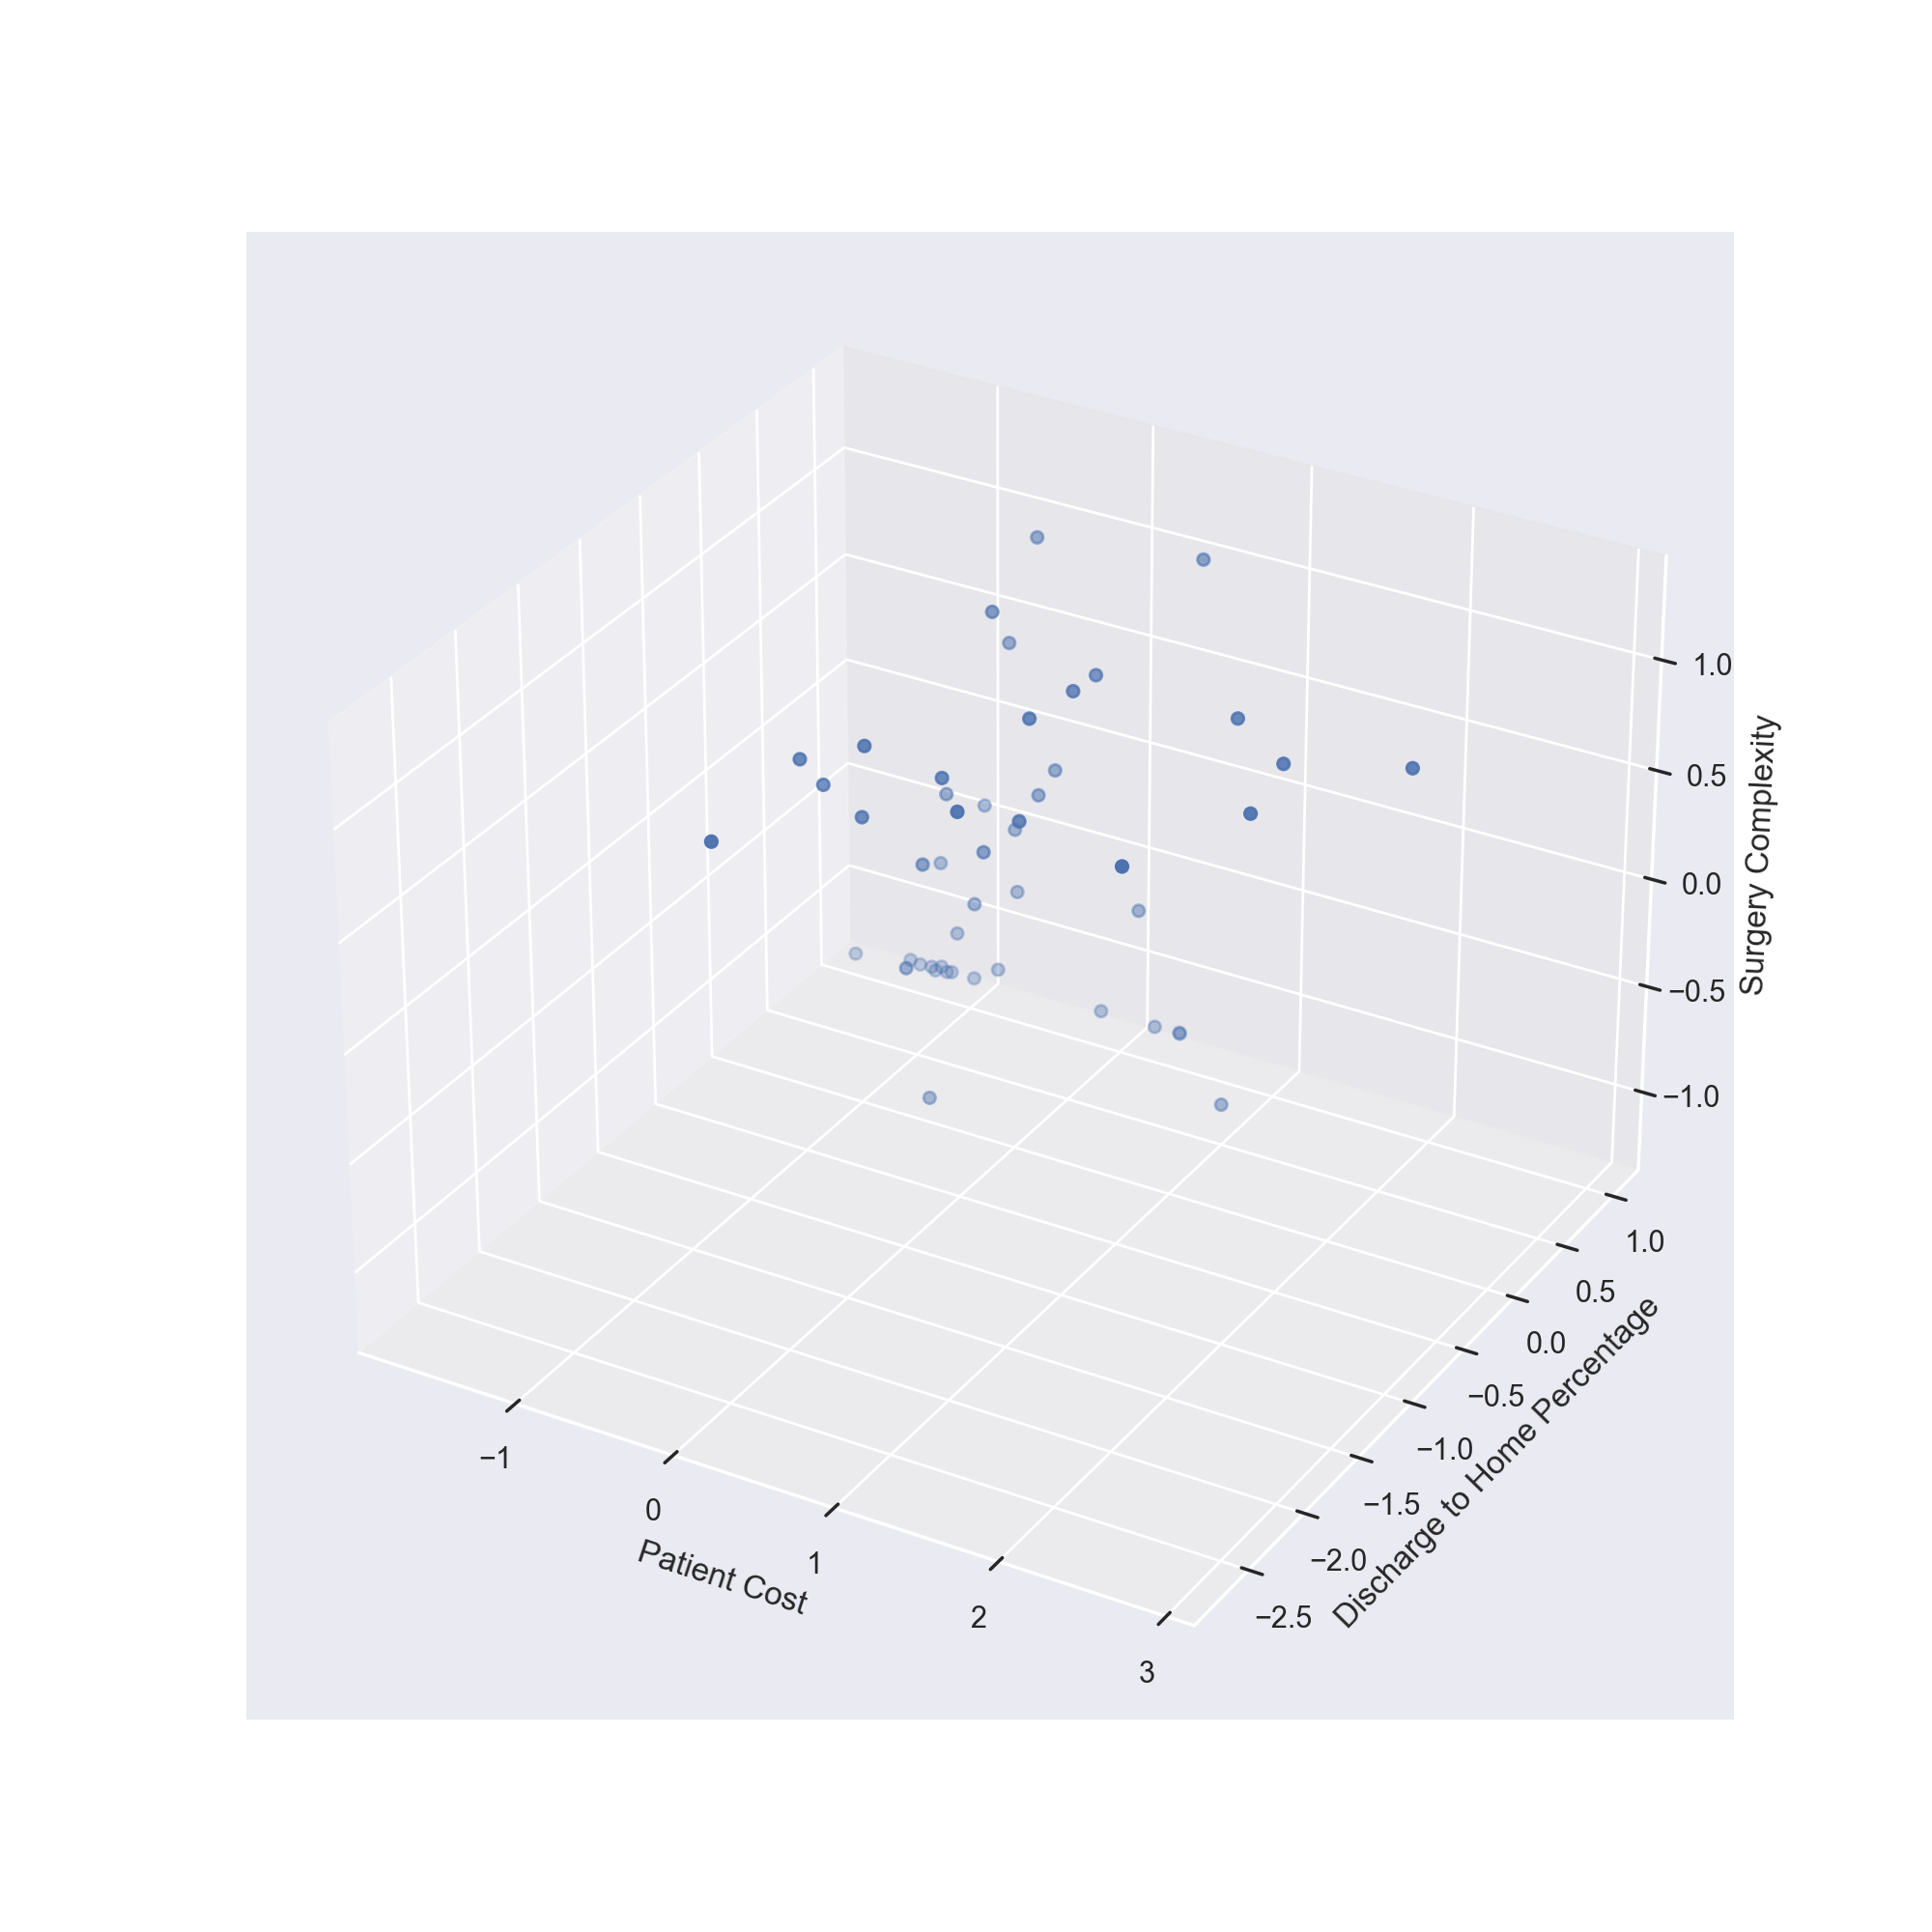

In [8]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

x = norm_group_df['pat_cost']
y = norm_group_df['discharge_to_home_pct']
z = norm_group_df['IP_pct']

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z)

plt.show()


## Performing preliminary clustering

### KMEANS

In [9]:
X = group_df[['pat_cost','discharge_to_home_pct','IP_pct']].values

In [10]:
# determining the optimal number of clusters
clusters = np.arange(1,10)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    inertia.append(model.inertia_)

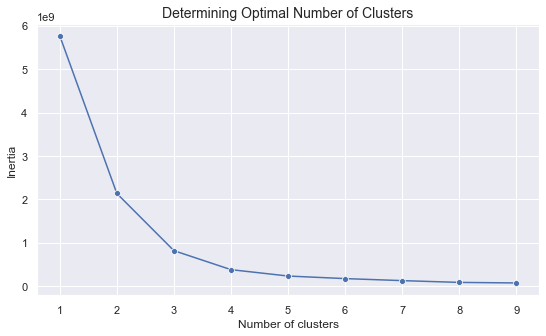

In [11]:
%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

**Optimal number of clusters = 3**

In [12]:
optimal_model = KMeans(n_clusters = 3, n_init = 550).fit_predict(X)

In [13]:
cluster_df = group_df.copy()
cluster_df['cluster'] = optimal_model

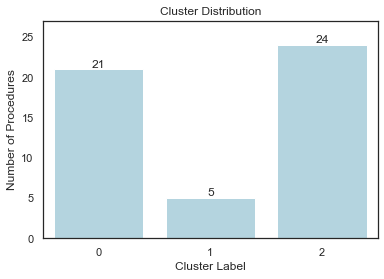

In [14]:
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
# plt.savefig(path+'/figures/kmeans_optimal_clusters_barplot.png', bbox_inches = 'tight')
plt.show()

In [15]:
cluster_df[cluster_df.cluster == 1]

,group,pat_cost,discharge_to_home_pct,phy_spec,IP_pct,cluster
2,ant_tls_fusion,49478.1242,0.596666,ORTHOPEDIC SURGERY (ORS),0.983543,1
16,hepat,38551.9350,0.589055,GENERAL SURGERY (GS),0.994722,1
20,intracranial_thromb,41302.4483,0.247098,INTERNAL MEDICINE (IM),0.996995,1
33,post_cerv_fusion,44165.0556,0.423994,NEUROLOGICAL SURGERY (NS),0.984928,1
34,post_tls_fusion,42731.6593,0.546070,NEUROLOGICAL SURGERY (NS),0.975788,1


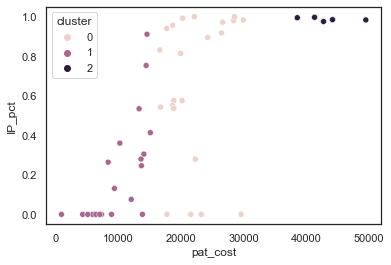

In [81]:
%matplotlib inline
sns.scatterplot(x = 'pat_cost', y = 'IP_pct', data = cluster_df, hue = 'cluster')
plt.show()

<IPython.core.display.Javascript object>


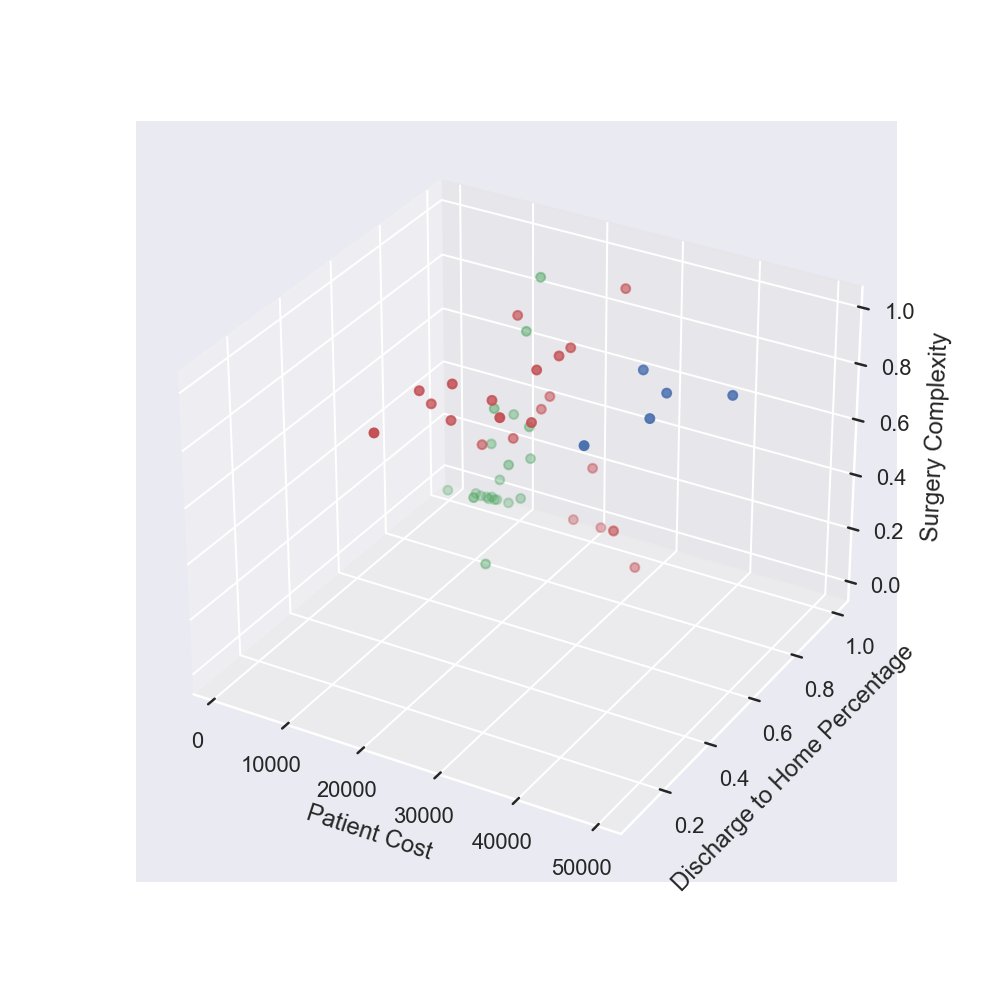

In [82]:
sns.set(style = "darkgrid")

%matplotlib notebook
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['pat_cost']
y = cluster_df['discharge_to_home_pct']
z = cluster_df['IP_pct']

col=cluster_df['cluster'].map({0:'r',1:'g',2:'b'})

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z, color = col)

plt.show()

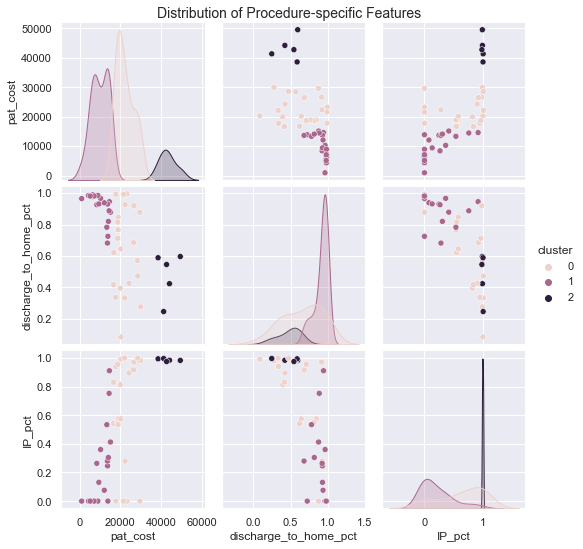

In [83]:
%matplotlib inline
f = sns.pairplot(cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Procedure-specific Features', y = 1.01, fontsize = 14)
#plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

In [18]:
#cluster_df[['group','cluster']].to_csv(path+'/Kmeans_clusters/unstandardized_clusters.csv', index=False)

### Normalized KMeans

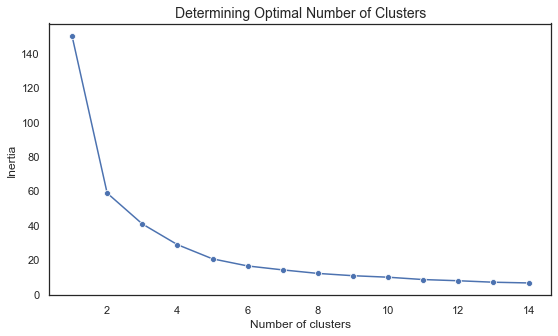

In [16]:
X_norm = norm_group_df[['pat_cost','discharge_to_home_pct','IP_pct']].values
# determining the optimal number of clusters
clusters = np.arange(1,15)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X_norm)
    inertia.append(model.inertia_)
    

%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

**Optimal number of clusters = 3**

In [25]:
num_clusters = 3
norm_optimal_model = KMeans(n_clusters = num_clusters, n_init = 250).fit_predict(X_norm)

In [26]:
norm_cluster_df = norm_group_df.copy()
norm_cluster_df['cluster'] = norm_optimal_model
norm_cluster_df['group'] = group_df.group

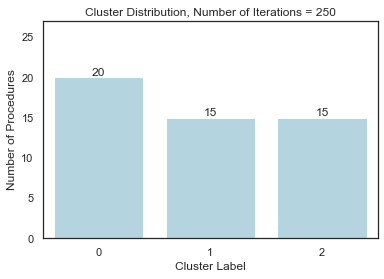

In [27]:
%matplotlib inline
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = norm_cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution, Number of Iterations = 250')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
#plt.savefig(path+'/figures/km_optimal_normclusters_iter250.png', bbox_inches = 'tight')
plt.show()

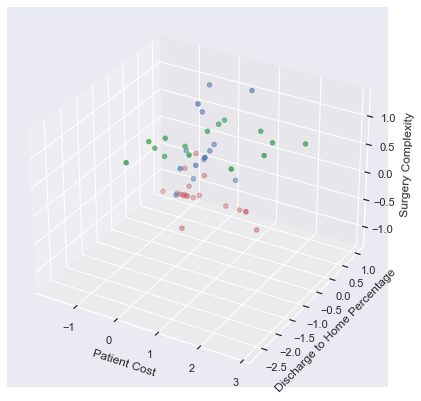

In [28]:
sns.set(style = "darkgrid")

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection = '3d')

x = norm_cluster_df['pat_cost']
y = norm_cluster_df['discharge_to_home_pct']
z = norm_cluster_df['IP_pct']

col=norm_cluster_df['cluster'].map({0:'r',1:'g',2:'b',3:'y',4:'black'})

ax.set_xlabel("Patient Cost")
ax.set_ylabel("Discharge to Home Percentage")
ax.set_zlabel("Surgery Complexity")

ax.scatter(x, y, z, color = col)

plt.show()

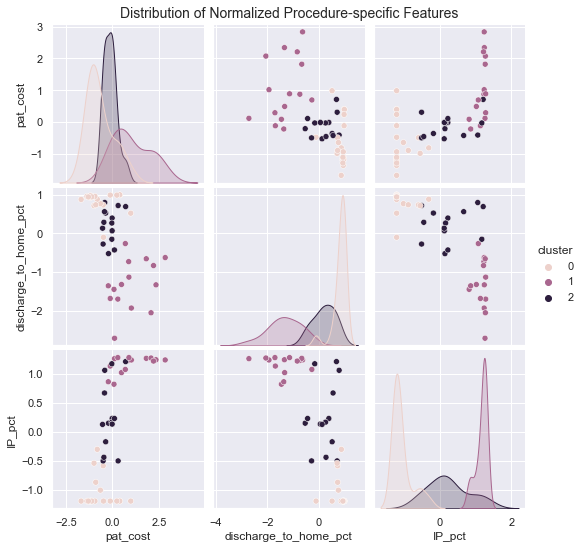

In [29]:
%matplotlib inline
f = sns.pairplot(norm_cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Normalized Procedure-specific Features', y = 1.01, fontsize = 14)
#plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

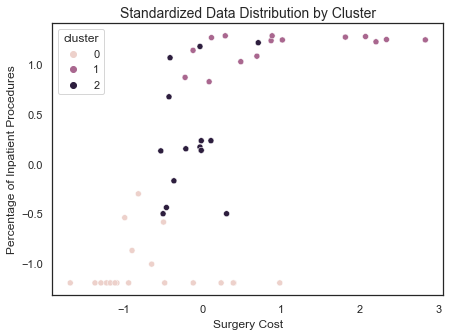

In [30]:
%matplotlib inline
sns.set_theme(style='white')
plt.figure(figsize = (7,5))
sns.scatterplot(x = 'pat_cost', y = 'IP_pct', data = norm_cluster_df, hue = 'cluster')
plt.title('Standardized Data Distribution by Cluster', fontsize = 14)
plt.xlabel('Surgery Cost', fontsize = 12)
plt.ylabel('Percentage of Inpatient Procedures', fontsize = 12)
plt.savefig(path+'/figures/cost_complexity_NormKMeans.png', bbox_inches = 'tight')
plt.show()

In [32]:
for i in range(num_clusters):
    norm_cluster_df[norm_cluster_df.cluster == i][['group']].to_csv(path+'/Kmeans_clusters/standardized/group'+
                                                          str(i)+'.csv', index=False)

#### Plotting clusters

**There are 2 procedures that are not in the procedure data shared with us**

In [27]:
set(data.group)-set(cluster_df.group)

{'bdet', 'post_TLS_fusion'}

In [28]:
merged_data = pd.merge(data, cluster_df[['group','cluster']].drop_duplicates(), 
                       left_on = 'group', right_on = 'group')

In [29]:
# applying some preprocessing
merged_data.dropna(subset = 'priv_pay_median', inplace = True)
merged_data = merged_data[merged_data.priv_count != 0]
merged_data = merged_data[merged_data.priv_pay_median > 1]

In [30]:
merged_data = merged_data[merged_data.priv_count>=51]

In [31]:
m = MinMaxScaler()
merged_data['norm_priv_pay_median'] = m.fit_transform(merged_data['priv_pay_median'].values.reshape(-1,1))
merged_data['norm_mcare_pay_median'] = m.fit_transform(merged_data['mcare_pay_median'].values.reshape(-1,1))

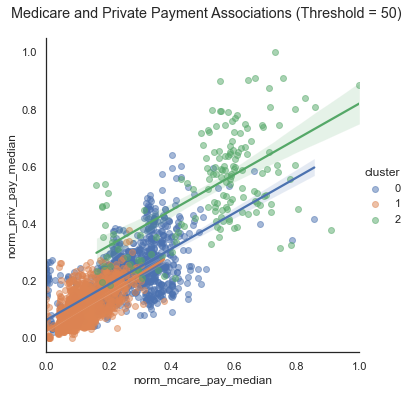

In [32]:
sns.set_theme(style='white')
g = sns.lmplot(x = 'norm_mcare_pay_median', y = 'norm_priv_pay_median', hue = 'cluster',
                data = merged_data, scatter_kws = {'alpha':0.5})
g.fig.suptitle('Medicare and Private Payment Associations (Threshold = 50)', y = 1.05)
#plt.savefig(path+'/figures/RregressionPayDist_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

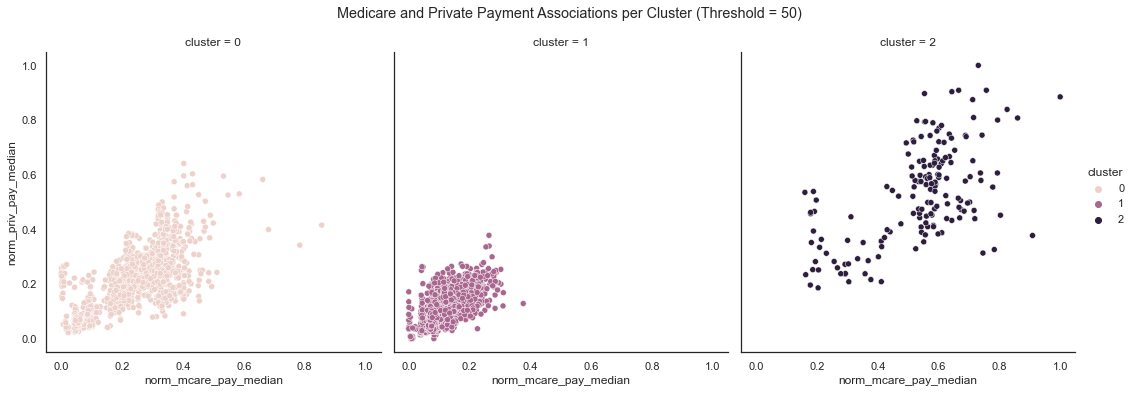

In [33]:
sns.set_theme(style='white')
g = sns.relplot(x = 'norm_mcare_pay_median', y = 'norm_priv_pay_median', col = 'cluster', hue = 'cluster',
                data = merged_data)
g.fig.suptitle('Medicare and Private Payment Associations per Cluster (Threshold = 50)', y = 1.05)
#plt.savefig(path+'/figures/FilteredPayDist_kmeans_optimal_normClusters.png', bbox_inches = 'tight')
plt.show()

#### Checking stability of clusters

In [242]:
num_clusters = 3
optimal_model = KMeans(n_clusters = num_clusters, n_init = 500).fit_predict(X_norm)

cluster_df500 = norm_group_df.copy()
cluster_df500['cluster500'] = optimal_model
cluster_df500['group'] = group_df.group

num_clusters = 3
optimal_model = KMeans(n_clusters = num_clusters, n_init = 250).fit_predict(X_norm)

cluster_df250 = norm_group_df.copy()
cluster_df250['cluster250'] = optimal_model
cluster_df250['group'] = group_df.group

In [243]:
temp = pd.merge(cluster_df250[['group','cluster250']], cluster_df500[['group','cluster500']], on = 'group')

In [244]:
temp = cluster_df500[['group','cluster500']].groupby('cluster500').size().reset_index()
temp.rename(columns = {0:'iter500'}, inplace = True)
temp = pd.merge(temp, cluster_df250[['group','cluster250']].groupby('cluster250').size().reset_index(),\
               left_on = 'cluster500', right_on = 'cluster250')

In [245]:
temp.rename(columns = {0:'iter250'}, inplace = True)

In [246]:
temp = temp[['cluster500','iter500','iter250']]
temp = temp.melt(id_vars = 'cluster500', value_vars = ['iter500','iter250'])
temp.rename(columns = {'cluster500':'cluster','value':'num','variable':'iteration'}, inplace = True)

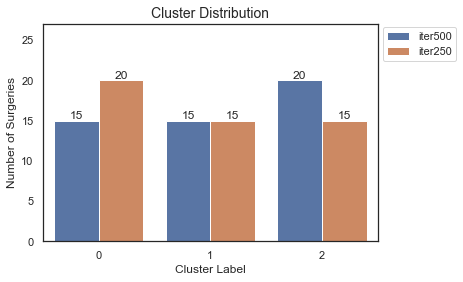

In [247]:
ax = sns.barplot(x = 'cluster', y = 'num',data = temp, hue = 'iteration')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.legend(bbox_to_anchor = (1.25,1.01))
plt.title('Cluster Distribution', fontsize = 14)
plt.xlabel('Cluster Label', fontsize = 12)
plt.ylabel('Number of Surgeries', fontsize = 12)
#plt.savefig(path+'/figures/unstable_normClusters.png', bbox_inches = 'tight')
plt.show()

### Partially normalized KMeans

In [33]:
m = MinMaxScaler()
p_norm_group_cost = group_df.copy()[['pat_cost']]

p_norm_group_cost = m.fit_transform(p_norm_group_cost.values)

In [34]:
p_norm_group_cost_df = group_df.copy()
p_norm_group_cost_df['pat_cost'] = p_norm_group_cost.reshape(1,-1)[0]
p_norm_group_cost_df.drop(columns = 'discharge_to_home_pct', inplace = True)

In [35]:
p_norm_group_cost_df.describe()

,pat_cost,IP_pct
count,50.000000,50.000000
mean,0.372383,0.481851
std,0.223544,0.407676
min,0.000000,0.000000
25%,0.235659,0.000000
50%,0.355860,0.535416
75%,0.460397,0.935125
max,1.000000,1.000000


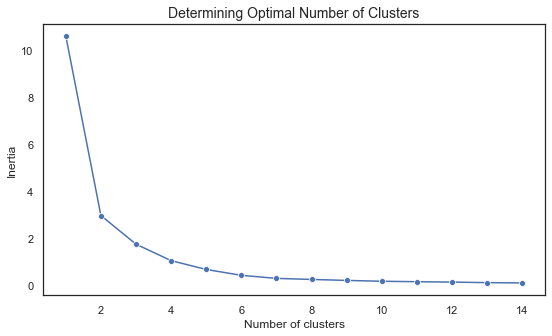

In [36]:
X_partial = p_norm_group_cost_df[['pat_cost','IP_pct']].values
# determining the optimal number of clusters
clusters = np.arange(1,15)
inertia = []
for k in clusters:
    model = KMeans(n_clusters = k)
    model.fit(X_partial)
    inertia.append(model.inertia_)
    

%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

In [37]:
num_clusters = 3
partial_optimal_model = KMeans(n_clusters = num_clusters, n_init = 500).fit_predict(X_partial)

In [38]:
p_cluster_df = p_norm_group_cost_df.copy()
p_cluster_df['cluster'] = partial_optimal_model

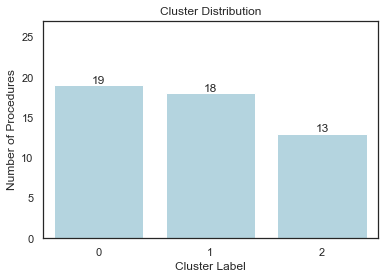

In [39]:
sns.set_theme(style='white')
plt.figure(figsize = (6,4))
ax = sns.barplot(x = 'cluster', y = 0, data = p_cluster_df.groupby(by = 'cluster').size().reset_index(),\
            color = 'lightblue')
ax.set_ylim(0,27)
ax.bar_label(ax.containers[0])
ax.set_title('Cluster Distribution')
ax.set_ylabel('Number of Procedures')
ax.set_xlabel('Cluster Label')
# plt.savefig(path+'/figures/kmeans_optimal_clusters_barplot.png', bbox_inches = 'tight')
plt.show()

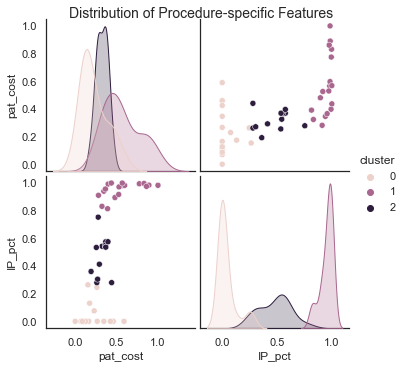

In [40]:
%matplotlib inline
f = sns.pairplot(p_cluster_df, hue = 'cluster')
f.fig.suptitle('Distribution of Procedure-specific Features', y = 1.01, fontsize = 14)
#plt.savefig(path+'/figures/pairplotFeatures_kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

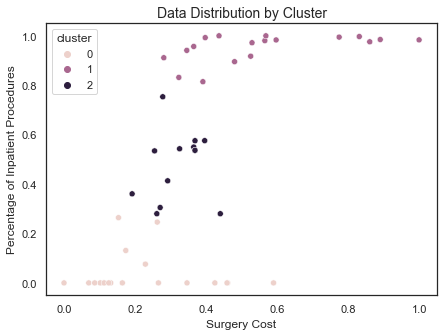

In [41]:
%matplotlib inline
plt.figure(figsize = (7,5))
sns.scatterplot(x = 'pat_cost', y = 'IP_pct', data = p_cluster_df, hue = 'cluster')
plt.title('Data Distribution by Cluster', fontsize = 14)
plt.xlabel('Surgery Cost', fontsize = 12)
plt.ylabel('Percentage of Inpatient Procedures', fontsize = 12)
#plt.savefig(path+'/figures/cost_complexity_partialNormKMeans.png', bbox_inches = 'tight')
plt.show()

In [42]:
p_cluster_df[['group','cluster']].to_csv(path+'/Kmeans_clusters/partial_standardized_clusters.csv', \
                                         index=False)

### KMeans Normalized Cost only

In [35]:
group_temp = group_df.copy()

# removing duplicated row
duplicated_index = \
group_temp[(group_temp.group == 'lung ablation')&(group_temp.phy_spec == 'HOSPITALIST (HOS)')].index
group_temp.drop(duplicated_index, inplace = True)

group_temp = group_temp[['group','pat_cost']]

In [36]:
s = StandardScaler()
norm_cost = s.fit_transform(np.array(group_temp['pat_cost']).reshape(-1,1)).reshape(1,-1)[0]
group_temp['norm_pat_cost'] = norm_cost

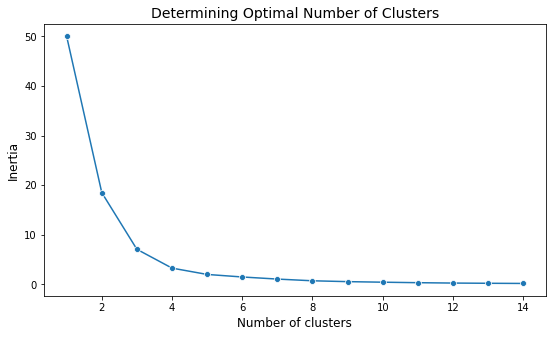

In [37]:
# finding optimal number of clusters

X_cost = group_temp[['norm_pat_cost']].values
num_clusters = np.arange(1,15)
inertia = []
for num in num_clusters:
    model = KMeans(n_clusters = num, n_init = 500).fit(X_cost)
    inertia.append(model.inertia_)
    
%matplotlib inline
plt.figure(figsize = (9,5))
sns.lineplot(x = num_clusters, y = inertia, marker = 'o')
plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Inertia', fontsize = 12)
plt.title('Determining Optimal Number of Clusters', fontsize = 14)
# plt.savefig(path+'/figures/kmeans_optimal_clusters.png', bbox_inches = 'tight')
plt.show()

In [47]:
optimal_clusters = 3
optimal_model = KMeans(n_clusters = optimal_clusters, n_init = 200).fit_predict(X_cost)

In [48]:
cluster_cost_df = group_temp.copy()
cluster_cost_df['cluster'] = optimal_model

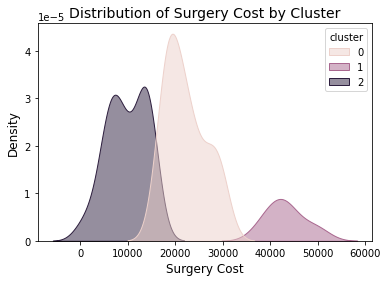

In [49]:
sns.kdeplot(data = cluster_cost_df, x = 'pat_cost', hue = 'cluster', fill = True, alpha = 0.5)

plt.title('Distribution of Surgery Cost by Cluster', fontsize = 14)
plt.xlabel('Surgery Cost', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
#plt.savefig(path+'/figures/cost_KMeans_dist.png', bbox_inches = 'tight')
plt.show()

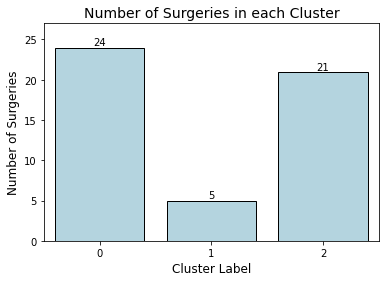

In [50]:
ax = sns.barplot(data = cluster_cost_df.groupby('cluster').size().reset_index(), x = 'cluster', y = 0, \
            color = 'lightblue', edgecolor = 'black')
ax.bar_label(ax.containers[0])
plt.ylim(0,27)
plt.title('Number of Surgeries in each Cluster', fontsize = 14)
plt.ylabel('Number of Surgeries', fontsize = 12)
plt.xlabel('Cluster Label', fontsize = 12)
#plt.savefig(path+'/figures/cost_KMeans_cluster_bar.png', bbox_inches = 'tight')
plt.show()

In [51]:
# saving clusters
# cluster_cost_df[['group','cluster']].to_csv(path+'/Kmeans_clusters/clusters_only_using_NormCost.csv', \
#                                          index=False)

In [10]:
cluster_cost_df = pd.read_csv(path+'/Kmeans_clusters/clusters_only_using_NormCost.csv')

#### Checking linearity

In [45]:
cluster_cost_df['cluster'] = cluster_cost_df['cluster'].replace(2,0.1)
cluster_cost_df['cluster'] = cluster_cost_df['cluster'].replace(0,2)
cluster_cost_df['cluster'] = cluster_cost_df['cluster'].replace(0.1,0)
cluster_cost_df['cluster'] = cluster_cost_df['cluster'].astype(int)

In [46]:
cluster_cost_df['group'] = list(map(lambda s: s.replace('\xa0',' '), cluster_cost_df['group']))
merged_temp = pd.merge(data, cluster_cost_df[['group','cluster']], on = 'group')

# pre-processing
merged_temp.dropna(subset = ['priv_pay_median'], inplace = True)
merged_temp = merged_temp[merged_temp.priv_count >= 35]

In [47]:
# normalizing medicare and commercial payments
m = MinMaxScaler()
l = m.fit_transform(merged_temp[['priv_pay_median','mcare_pay_median']])
merged_temp['norm_priv_pay_median'] = [x[0] for x in l]
merged_temp['norm_mcare_pay_median'] = [x[1] for x in l]

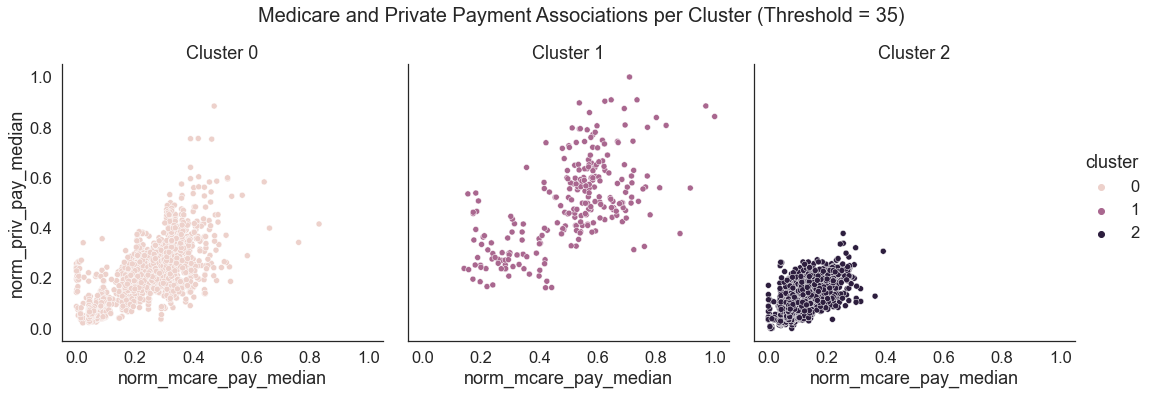

In [51]:
sns.set_theme(style='white', font_scale = 1.5)
# sns.set(font_scale = 1.5)
g = sns.relplot(x = 'norm_mcare_pay_median', y = 'norm_priv_pay_median', col = 'cluster', hue = 'cluster',
                data = merged_temp)
g.fig.suptitle('Medicare and Private Payment Associations per Cluster (Threshold = 35)', y = 1.05, \
               fontsize = 20)
g.set_titles(col_template = 'Cluster {col_name}', size = 18)
plt.savefig(path+'/figures/linearity_check_costClusters.png', bbox_inches = 'tight')


plt.show()